In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Modelling imports
from statsmodels.tsa.arima_model import ARIMA
#from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.core import Activation
import tensorflow as tf
from keras.initializers import glorot_uniform

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

import random
from numpy.random import seed

import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')

In [70]:
def show_graph(train, test=None, pred=None, title=None):
    
    fig = plt.figure(figsize=(20, 5))

    # entire data
    ax1 = fig.add_subplot(121)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Open')
    ax1.plot(train.index, train['Open'], color='green', label='Train price')
    if test is not None:
        ax1.plot(test.index, test['Open'], color='red', label='Test price')
    if pred is not None:
        if 'yhat' in pred.columns:
            ax1.plot(pred.index, pred['Price'], color = 'blue', label = 'Predicted price')
            ax1.fill_between(pred.index, pred['price_lower'], pred['price_upper'], color='grey', label="Band Range")
        else:
            ax1.plot(pred.index, pred['Price'], color='blue', label='Predicted price')
    ax1.legend()
    if title is not None:
        plt.title(title + ' (Entire)')
    plt.grid(True)

    # zoom data
    period=50
    period=int(0.2*len(train))
    ax2 = fig.add_subplot(122)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Open')
    ax2.plot(train.index[-period:], train['Open'].tail(period), color='green', label='Train price')
    if test is not None:
        ax2.plot(test.index, test['Open'], color='red', label='Test price')
    if pred is not None:
        if 'yhat' in pred.columns:
            ax2.plot(pred.index, pred['Price'], color = 'blue', label = 'Predicted price')
            ax2.fill_between(pred.index, pred['Price_lower'], pred['Price_upper'], color='grey', label="Band Range")
        else:
            ax2.plot(pred.index, pred['Price'], color='blue', label='Predicted price')
    ax2.legend()
    if title is not None:
        plt.title(title + ' (Recent ' + str(period) + ')')
    plt.grid(True)

    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
def make_future_dates(last_date, period):
    prediction_dates=pd.date_range(last_date, periods=period+1, freq='B')
    return prediction_dates[1:]

def calculate_accuracy(forecast, actual, algorithm):
    mse  = round(mean_squared_error(actual, forecast),4)
    mae  = round(mean_absolute_error(actual, forecast),4)
    rmse = round(sqrt(mean_squared_error(actual, forecast)),4)
    return ({'algorithm':algorithm, 'mse':mse, 'mae':mae, 'rmse': rmse})

In [71]:
start = dt.datetime(2010,1,1)
end = dt.datetime.now()
tickers = ['PFE', 'MRNA', 'JNJ', 'AZN']

filenames = []

for ticker in tickers:
    if ticker == 'MRNA':
        df = yf.download(ticker, dt.datetime(2018,12,7), end)
    else:
        df = yf.download(ticker, start, end)
    filename = f'{ticker}_stock_prices.csv'
    filenames.append(filename)
    df.to_csv(filename)
    
for filename in filenames:
    if filename.startswith('AZN'):
        azn_df = pd.read_csv('AZN_stock_prices.csv', index_col='Date', parse_dates=True)
    elif filename.startswith('MRNA'):
        mrna_df = pd.read_csv('MRNA_stock_prices.csv', index_col='Date', parse_dates=True)
    elif filename.startswith('JNJ'):
        jnj_df = pd.read_csv('JNJ_stock_prices.csv', index_col='Date', parse_dates=True)
    else:
        pfe_df = pd.read_csv('PFE_stock_prices.csv', index_col='Date', parse_dates=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [72]:
azn_df.dropna()
azn_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,23.709999,23.764999,23.575001,23.705000,13.959425,2606200
2010-01-05,23.434999,23.465000,23.150000,23.225000,13.676762,2666600
2010-01-06,22.915001,23.045000,22.785000,23.040001,13.567821,3020800
2010-01-07,23.250000,23.325001,23.120001,23.290001,13.715042,4454600
2010-01-08,23.270000,23.415001,23.174999,23.389999,13.773925,2675600


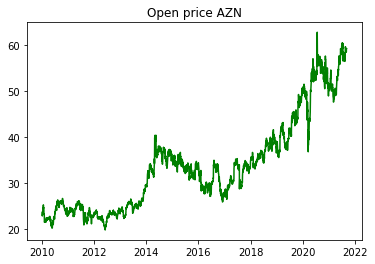

In [73]:
#Plot real closing Prices
#pd.show()
#plot each series
plt.plot(azn_df["Open"], color='green')
plt.title("Open price AZN")
plt.show()



No handles with labels found to put in legend.


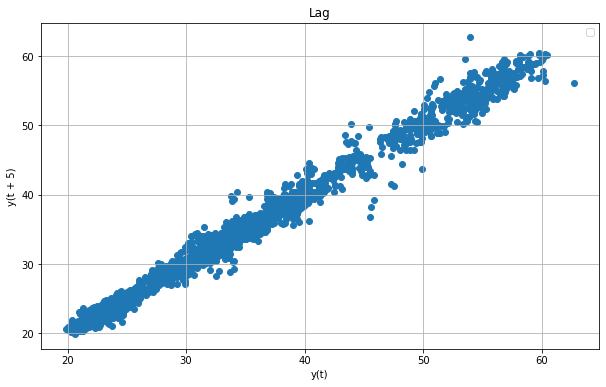

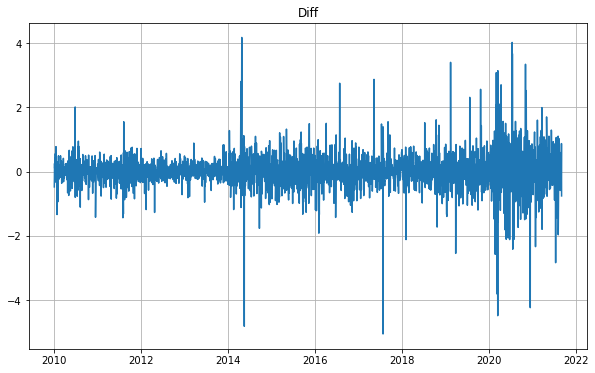

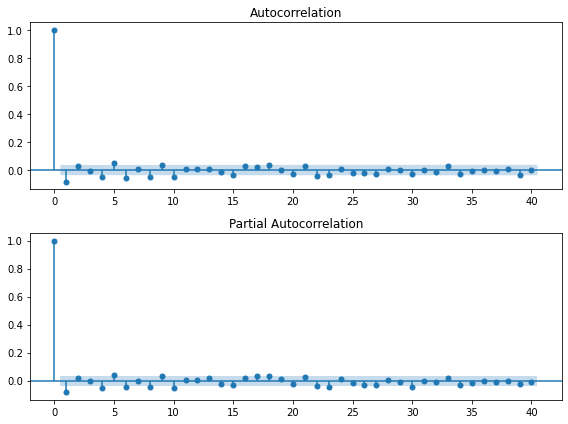

In [74]:
#Autocorrelation plot

fig = plt.figure(figsize=(10, 6))
lag_plot(azn_df['Open'], lag=5)
plt.title('Lag')
plt.grid(True)
plt.legend();

# Show Diff
anz_diff = azn_df['Close'] - azn_df['Close'].shift() 
anz_diff = anz_diff.dropna()
plt.figure(figsize=(10, 6))
plt.title('Diff')
plt.grid(True)
plt.plot(anz_diff);

fig = plt.figure(figsize=(8, 6))

# Show ACF
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(anz_diff, lags=40, ax=ax1)

# Show PACF
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(anz_diff, lags=40, ax=ax2)

plt.tight_layout()


In [87]:
#AstraZeneca (AZN). 

# Test to see if the data is stationary or non-stationary.
# Convert to stationary if needed. 

adfuller(azn_df.Close)

(-0.22606109303251098,
 0.9353430683475987,
 23,
 2915,
 {'1%': -3.432595306291141,
  '5%': -2.862532026483452,
  '10%': -2.5672980835802277},
 4803.040785535637)

<Figure size 1440x2880 with 0 Axes>

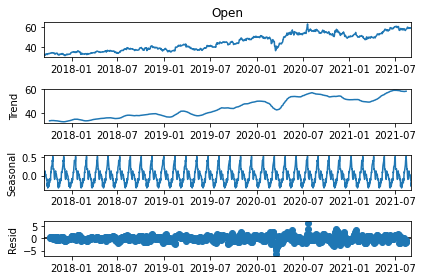

In [75]:
result_azn = seasonal_decompose(azn_df.Open[-1000:], model='additive', freq=30)
plt.figure(figsize=(20,40))
fig = result_azn.plot()
plt.show()

In [76]:
values = DataFrame(azn_df['Open'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.994648  0.988681  0.966747  0.998500
t+1   0.994648  1.000000  0.993429  0.970217  0.993499
t+5   0.988681  0.993429  1.000000  0.975924  0.987523
t+10  0.966747  0.970217  0.975924  1.000000  0.965863
t+30  0.998500  0.993499  0.987523  0.965863  1.000000


In [77]:
#ADF test

adf_result_azn = sm.tsa.stattools.adfuller(azn_df['Open'].values, autolag ='AIC')
adf = pd.Series(adf_result_azn[0:4], index = ['Test Statistic', 'p-　　value', '#Lags Used', 'Number of Observations Used'])
print(adf)

Test Statistic                   -0.250756
p-　　value                         0.932195
#Lags Used                       17.000000
Number of Observations Used    2921.000000
dtype: float64


In [82]:
# ARMA Model

##Create an ARMA model and fit it to the data. Output the summary table and take note of the p-values of the lags.

###Plot the Forecast for the next 5 days of each Stock changes
from statsmodels.tsa.arima_model import ARMA

In [85]:
# AstraZeneca (AZN)
model_azn = ARMA(azn_df.Open.values, order=(2, 2))
result_azn = model_azn.fit()
result_azn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 2939
Model:                     ARMA(2, 2)   Log Likelihood               -2412.593
Method:                       css-mle   S.D. of innovations              0.549
Date:                Mon, 06 Sep 2021   AIC                           4837.187
Time:                        22:50:10   BIC                           4873.102
Sample:                             0   HQIC                          4850.119
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.5103        nan        nan        nan         nan         nan
ar.L1.y        1.9589   1.33e-05   1.48e+05      0.000       1.959       1.959
ar.L2.y       -0.9589    6.5e-06  -1.48e+05      0.000      -0.959      -0.959
ma.L1.y       -1.0186      0.019    -54.324      0.000      -1.055      -0.982
ma.L2.y        0.0444      0.019      2.357      0.018       0.007       0.081
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0000           +0.0000j            1.0000            0.0000
AR.2            1.0428           +0.0000j            1.0428            0.0000
MA.1            1.0278           +0.0000j            1.0278            0.0000
MA.2           21.9254           +0.0000j           21.9254            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'AstraZeneca Forecasting'}>

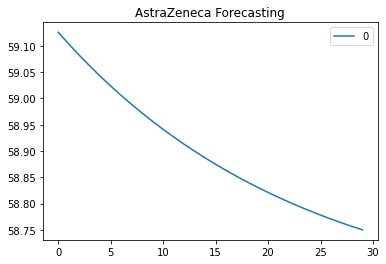

In [86]:
# Forecasting the future AstraZeneca (AZN).
pd.DataFrame(result_azn.forecast(steps=30)[0]).plot(title="AstraZeneca Forecasting")